In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
grn_size=50
ones=torch.ones(1,int(grn_size/2)).to(device)
zeros=torch.zeros(1,int(grn_size/2)).to(device)
targA=torch.cat((ones,zeros),1)
targB=torch.cat((zeros,ones),1)

In [5]:
def get_phenotypes(pop, num_indv):
    state = torch.zeros(num_indv, 1, grn_size).to(device)
    state[:, :, 0] = 1.0 # create input to the GRNs

    for i in range(max_iter):
        state = torch.matmul(state, pop) # each matrix in the population is multiplied
        state = state * alpha
        state = torch.sigmoid(state) # after which it is put in a sigmoid function to get the output, by default alpha = 1 which is pretty flat, so let's use alpha > 1 (wagner uses infinite) hence the above multiplication
  
    return state

# Old way of defining diversifier, conservative

In [6]:
# Conservative: close to being 0.5 fitness in both environments
def cons_spec(pop):
    phenos=get_phenotypes(pop,len(pop))
    a=(1- torch.abs(targA - phenos.squeeze(1))).sum(axis=1)/50
    b=(1- torch.abs(targB - phenos.squeeze(1))).sum(axis=1)/50
    con = 1-(abs(a-0.5)+abs(b-0.5)/2) #min 0.25, max 1
    return phenos, con, a, b

In [7]:
#standard deviation between children phenotypes
def diver(pop, if_pheno=False):
     
    num_clones=20
    clones = pop.repeat([num_clones, 1, 1])

    # Mutate clones
    num_genes_mutate = int(grn_size*grn_size*len(clones) * mut_rate)
    mylist = torch.zeros(grn_size*grn_size*len(clones), device=device)
    mylist[:num_genes_mutate] = 1
    shuffled_idx = torch.randperm(grn_size*grn_size*len(clones), device=device)
    mask = mylist[shuffled_idx].reshape(len(clones),grn_size,grn_size) #select genes to mutate
    clones = clones + (clones*mask)*torch.randn(size=clones.shape, device=device) * mut_size  # mutate only clones only at certain genes

    # Get clone phenotypes
    clone_phenos=get_phenotypes(clones, len(clones))
    
    #If just getting phenos
    if if_pheno:
        return torch.squeeze(clone_phenos)
    
    else:
        reshaped=torch.reshape(clone_phenos, (num_clones, len(pop), grn_size))

        stds=torch.std(reshaped,dim=(0)) #mean across the 50 genes
        stds=stds.mean(1)#.mean().item()
    
        return stds


In [8]:
pop_size=1000
max_iter=100 #could play with this
alpha=10
mut_rate=0.1
mut_size=0.5

In [9]:
myset = torch.randn((pop_size, grn_size, grn_size)).to(device)

In [10]:
phenos, con, a, b = cons_spec(myset)

In [11]:
div=diver(myset)

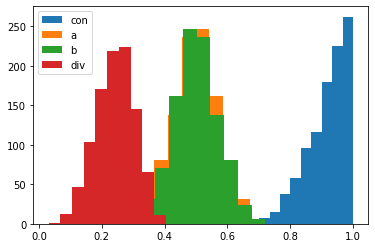

In [12]:
plt.hist(con.cpu(), label="con")
plt.hist(a.cpu(), label="a")
plt.hist(b.cpu(), label="b")
plt.hist(div.cpu(), label="div")
plt.legend()
#fig = plt.figure(figsize=(2,2))
#plt.matshow(torch.squeeze(phenos).cpu())

### As you can see, random networks generate phenotypes that are in-between, hence all (or most) of them are "conservative bet-hedgers". Also, std reaches 0.4! so are these "diversifying bet-hedgers"?


In [13]:
#find most diversifier
most_diver=myset[np.argsort(div.cpu().detach().numpy())[-1]]
most_diver.shape

torch.Size([50, 50])

In [14]:
t_phenos=diver(most_diver, if_pheno=True)
t_phenos.shape

torch.Size([20, 50])

<Figure size 144x144 with 0 Axes>

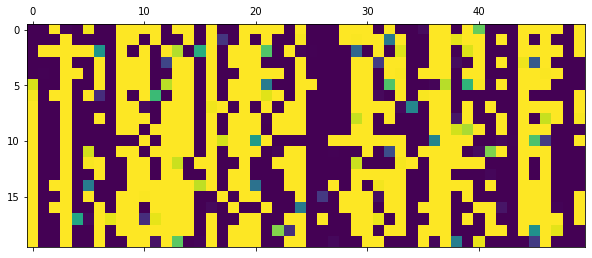

In [15]:
fig = plt.figure(figsize=(2,2))
plt.matshow(t_phenos.cpu()[t_phenos.cpu()[:, 0].sort()[1]])

### As you can see, you can be a "diversifying bet-hedger" even if the alternatives are really far from a good solution. like you can have a random number of genes on, as long as other kids have those genes off and the rest on, we are classifying it as a diversifyer. So clearly, at least this definition is wrong for our purposes

### New definition of conservative: number of genes close to the value 0.5

### New definition of diversifier: std in fitnesses!?

In [16]:
# Conservative: close to being 0.5 fitness in both environments
def cons_spec(pop):
    phenos=get_phenotypes(pop,len(pop))
    a=(1- torch.abs(targA - phenos.squeeze(1))).sum(axis=1)/50
    b=(1- torch.abs(targB - phenos.squeeze(1))).sum(axis=1)/50
    
    phenos=torch.squeeze(phenos)
    con=1-(abs(phenos-0.5).mean(1)) #value between 0.5 and 1, higher more conservative
    con=(con-0.5) *2 #rescaled to value between 0 and 1

    return phenos, con, a, b

In [19]:
#standard deviation between children phenotypes
def diver(pop, if_pheno=False):
     
    num_clones=20
    clones = pop.repeat([num_clones, 1, 1])

    # Mutate clones
    num_genes_mutate = int(grn_size*grn_size*len(clones) * mut_rate)
    mylist = torch.zeros(grn_size*grn_size*len(clones), device=device)
    mylist[:num_genes_mutate] = 1
    shuffled_idx = torch.randperm(grn_size*grn_size*len(clones), device=device)
    mask = mylist[shuffled_idx].reshape(len(clones),grn_size,grn_size) #select genes to mutate
    clones = clones + (clones*mask)*torch.randn(size=clones.shape, device=device) * mut_size  # mutate only clones only at certain genes

    # Get clone phenotypes
    clone_phenos=get_phenotypes(clones, len(clones))
    clone_phenos=torch.squeeze(clone_phenos)
    
    #If just getting phenos
    if if_pheno:
        return clone_phenos
    
    else:
        reshaped=torch.reshape(clone_phenos, (num_clones, len(pop), grn_size))
        kid_fits=abs(reshaped-targA).sum(axis=2).T /grn_size #each row is 20 kids of the same parent (their fitness)
        fit_stds=torch.std(kid_fits,dim=(1))

        return fit_stds


In [20]:
div=diver(myset, if_pheno=False)

In [21]:
phenos, con, a, b = cons_spec(myset)

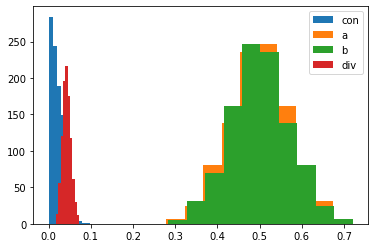

In [22]:
plt.hist(con.cpu(), label="con")
plt.hist(a.cpu(), label="a")
plt.hist(b.cpu(), label="b")
plt.hist(div.cpu(), label="div")
plt.legend()
#fig = plt.figure(figsize=(2,2))
#plt.matshow(torch.squeeze(phenos).cpu())

## Next: put in evolved networks to compare

# PCA

In [13]:
flat=pop.flatten(1)
flat.shape

torch.Size([1000, 2500])

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponentst = pca.fit_transform(flat.cpu())

In [16]:
len(principalComponentst[0])

2

In [17]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.00252629 0.00249684]


In [18]:
Df = pd.DataFrame(data = principalComponentst, columns = ['principal component 1', 'principal component 2'])

In [19]:
Df

,principal component 1,principal component 2
0,0.483794,3.100078
1,-2.302217,2.276360
2,-0.113296,3.303546
3,2.173040,3.035298
4,-2.349537,-1.184378
...,...,...
995,-5.591148,0.962508
996,1.225144,-1.811843
997,-0.614982,-0.983988
998,-1.018109,2.820617


<Figure size 432x288 with 0 Axes>

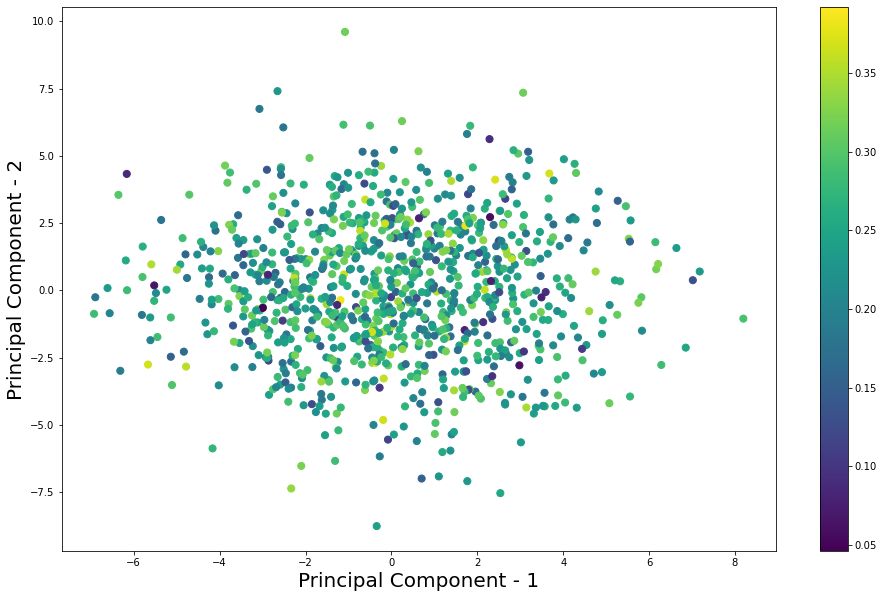

In [22]:
plt.figure()
plt.figure(figsize=(16,10))
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)

plt.scatter(Df['principal component 1'], Df['principal component 2'], c = div.cpu(), s = 50)

plt.colorbar()